## Libraries

In [ ]:
from pyspark import SparkFiles
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, sum, corr
from pyspark.sql.functions import collect_set, count
from pyspark.ml.stat import Correlation
from pyspark.sql import functions as F
from pyspark.sql.functions import split, slice, size, concat_ws, when
from pyspark.ml.feature import Imputer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Data loading

In [ ]:
# Start spark session
spark = SparkSession.builder.appName('Spark-Group1-Flights').getOrCreate()

In [ ]:
# Load dataset

gcs_path = "gs://msca-bdp-student-gcs/Group1/itineraries.csv"
df = spark.read.csv(gcs_path, header=True, inferSchema=True)

# Show the dataframe
df.show(10)

24/11/18 19:15:08 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+--------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode| segmentsAirlineName|segmentsAirlineCode|segmentsEquipmentDescription|segmentsDurationInSeconds|segments

In [ ]:
# Repartition
num = df.rdd.getNumPartitions()
print(num)
df = df.repartition(num)

232


In [ ]:
# Get the number of rows
num_rows = df.count()

# Get the number of columns
num_columns = len(df.columns)

# Get the shape of the DataFrame
shape = (num_rows, num_columns)

In [ ]:
shape

(82138753, 27)

In [ ]:
# Drop columns that have duplicate or redundant information
df = df.drop("baseFare", "isBasicEconomy", "segmentsArrivalAirportCode", "segmentsDepartureTimeEpochSeconds",
             "segmentsArrivalTimeEpochSeconds", "segmentsAirlineCode", "fareBasisCode",
            "segmentsDurationInSeconds", "segmentsDistance", "segmentsDepartureTimeRaw")

In [ ]:
# See which cols have null vals and how many nulls vals there are
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns]) # no missing vals

null_counts.show()

+-----+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+-------------------+----------------------+----------------------------+-------------------+----------------------------+-----------------+
|legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|isNonStop|totalFare|seatsRemaining|totalTravelDistance|segmentsArrivalTimeRaw|segmentsDepartureAirportCode|segmentsAirlineName|segmentsEquipmentDescription|segmentsCabinCode|
+-----+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+-------------------+----------------------+----------------------------+-------------------+----------------------------+-----------------+
|    0|         0|         0|              0|                 0|             0|          0|           0|        0|        0|             0|            6094532|    

In [ ]:
# See types for each column
df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsDepartureAirportCode: string (nullable = true)
 |-- segmentsAirlineName: string (nullable = true)
 |-- segmentsEquipmentDescription: string (nullable = true)
 |-- segmentsCabinCode: string (nullable = true)



## Data Cleaning

### Fixing travel time

In [ ]:
# Make a copy of data for manipulations
copy_df = df

In [ ]:
# Repartition data
copy_df = copy_df.repartition(num)

In [ ]:
# Use regexp_extract to get the days, hours, and minutes components from the duration string
# Travelduration is stored in two different formats, one with Day and one with only hours, so have to handle both
temp_df = copy_df.withColumn("days", F.coalesce(F.regexp_extract("travelDuration", r"P(\d+)D", 1).cast("int"), F.lit(0)))

temp_df = temp_df.withColumn("hours", F.coalesce(F.regexp_extract("travelDuration", r"(\d+)H", 1).cast("int"), F.lit(0)))

temp_df = temp_df.withColumn("minutes", F.coalesce(F.regexp_extract("travelDuration", r"(\d+)M", 1).cast("int"), F.lit(0)))

In [ ]:
# Convert travelDuration column to minutes by summing total minutes from days hours and minutes
copy_df = temp_df.withColumn(
    "travelDuration",
    F.col("days") * 1440 + F.col("hours") * 60 + F.col("minutes")
)

In [ ]:
# Drop the temporary columns
copy_df = copy_df.drop("days", "hours", "minutes")

In [ ]:
# Check the travelDuration column converted correctly
copy_df.select("travelDuration").show()

+--------------+
|travelDuration|
+--------------+
|           800|
|           478|
|           478|
|           565|
|           565|
|           461|
|           461|
|           461|
|           601|
|           601|
|           189|
|           189|
|           485|
|           485|
|           485|
|           815|
|            93|
|            93|
|           166|
|           166|
+--------------+
only showing top 20 rows



#### Testing data cleaning on a small subset of data

In [ ]:
# Data cleaning on small subset of data to test that the cleaning works
smalldf = copy_df.limit(100).cache()

In [ ]:
# Convert search dates to date types
smalldf = smalldf.withColumn("searchDate", F.to_date(F.col("searchDate"), "yyyy-MM-dd"))

In [ ]:
# Convert flight dates to date type
smalldf = smalldf.withColumn("flightDate", F.to_date(F.col("flightDate"), "yyyy-MM-dd"))

In [ ]:
# Check that conversions were correct
smalldf.select("searchDate", "flightDate", "travelDuration").printSchema()

root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- travelDuration: integer (nullable = false)



In [ ]:
# Calculate the number of days that passed between search and flight date
smalldf = smalldf.withColumn("DaysBeforeFlight", F.datediff(F.col("flightDate"), F.col("searchDate")))

In [ ]:
# Check that calculation was correct
smalldf.select("searchDate", "flightDate", "DaysBeforeFlight").show()

+----------+----------+----------------+
|searchDate|flightDate|DaysBeforeFlight|
+----------+----------+----------------+
|2022-04-18|2022-05-07|              19|
|2022-04-18|2022-05-13|              25|
|2022-04-18|2022-05-09|              21|
|2022-04-18|2022-06-07|              50|
|2022-04-18|2022-05-18|              30|
|2022-04-18|2022-05-24|              36|
|2022-04-18|2022-04-29|              11|
|2022-04-18|2022-05-07|              19|
|2022-04-18|2022-05-21|              33|
|2022-04-18|2022-05-01|              13|
|2022-04-18|2022-05-02|              14|
|2022-04-18|2022-05-20|              32|
|2022-04-18|2022-05-05|              17|
|2022-04-18|2022-05-18|              30|
|2022-04-18|2022-05-06|              18|
|2022-04-18|2022-05-28|              40|
|2022-04-18|2022-06-04|              47|
|2022-04-18|2022-06-01|              44|
|2022-04-18|2022-05-07|              19|
|2022-04-18|2022-05-01|              13|
+----------+----------+----------------+
only showing top

In [ ]:
# Find all airports that layovers occured in and count number of layovers
smalldf = smalldf.withColumn('Layovers', split(smalldf['segmentsDepartureAirportCode'], '\|\|'))
smalldf = smalldf.withColumn('Layovers', slice(smalldf['Layovers'], 2, 10))
smalldf = smalldf.withColumn('NumStops', size(smalldf['Layovers']))

In [ ]:
# Check that the columns updated correctly
smalldf.select("segmentsDepartureAirportCode", "Layovers", "NumStops").show(10)

+----------------------------+----------+--------+
|segmentsDepartureAirportCode|  Layovers|NumStops|
+----------------------------+----------+--------+
|               DTW||IAD||ATL|[IAD, ATL]|       2|
|                    DTW||MCO|     [MCO]|       1|
|                         DEN|        []|       0|
|                    DTW||LAS|     [LAS]|       1|
|               LAX||AUS||IAH|[AUS, IAH]|       2|
|                         DFW|        []|       0|
|                    ORD||BOS|     [BOS]|       1|
|                    SFO||SLC|     [SLC]|       1|
|                    EWR||MCO|     [MCO]|       1|
|                    DFW||MCO|     [MCO]|       1|
+----------------------------+----------+--------+
only showing top 10 rows



In [ ]:
# Drop original column
smalldf = smalldf.drop("segmentsDepartureAirportCode")

In [ ]:
# Find all flight companies flewn and count number of unique flights
smalldf = smalldf.withColumn('AirlineNames', split(smalldf['segmentsAirlineName'], '\|\|'))
smalldf = smalldf.withColumn('UniqueAirlineNames', F.array_distinct(F.col('AirlineNames')))
smalldf = smalldf.withColumn('NumUniqueAirlines', F.size(F.col('UniqueAirlineNames')))

In [ ]:
# Check that the columns updated correctly
smalldf.select("segmentsAirlineName", "AirlineNames", "UniqueAirlineNames", "NumUniqueAirlines").show(10, truncate = False)

+--------------------------------+----------------------------------+-------------------------+-----------------+
|segmentsAirlineName             |AirlineNames                      |UniqueAirlineNames       |NumUniqueAirlines|
+--------------------------------+----------------------------------+-------------------------+-----------------+
|Delta||Delta||Delta             |[Delta, Delta, Delta]             |[Delta]                  |1                |
|Spirit Airlines||Spirit Airlines|[Spirit Airlines, Spirit Airlines]|[Spirit Airlines]        |1                |
|JetBlue Airways                 |[JetBlue Airways]                 |[JetBlue Airways]        |1                |
|Spirit Airlines||Spirit Airlines|[Spirit Airlines, Spirit Airlines]|[Spirit Airlines]        |1                |
|Alaska Airlines||United||United |[Alaska Airlines, United, United] |[Alaska Airlines, United]|2                |
|United                          |[United]                          |[United]           

In [ ]:
# Drop original and temporary columns
smalldf = smalldf.drop("segmentsAirlineName", "UniqueAirlineNames")

In [ ]:
# Find all flight craft types flewn and count number of unique crafts
smalldf = smalldf.withColumn('EquipmentDescriptions', split(smalldf['segmentsEquipmentDescription'], '\|\|'))
smalldf = smalldf.withColumn('UniqueEquipments', F.array_distinct(F.col('EquipmentDescriptions')))

In [ ]:
# Making a new column that tracks type of aircraft equipment that's used
# 0 = neither boeing or airbus
# 1 = boeing
# 2 = airbus
# 3 = both boeing and airbus

smalldf = smalldf.withColumn(
    "AircraftType",
    F.when(F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%boeing%'), true)") &
        F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%airbus%'), true)"), 3)
    .when(F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%boeing%'), true)"), 1)
    .when(F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%airbus%'), true)"), 2)
    .otherwise(0))

In [ ]:
# Check that the columns updated correctly
smalldf.select("segmentsEquipmentDescription", "EquipmentDescriptions", "UniqueEquipments", "AircraftType").show(10, truncate = False)

+----------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------+------------+
|segmentsEquipmentDescription                                    |EquipmentDescriptions                                             |UniqueEquipments                                                  |aircraftType|
+----------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------+------------+
|Canadair Regional Jet 900||Boeing 717||Boeing 717               |[Canadair Regional Jet 900, Boeing 717, Boeing 717]               |[Canadair Regional Jet 900, Boeing 717]                           |1           |
|AIRBUS INDUSTRIE A321 SHARKLETS||AIRBUS INDUSTRIE A321 SHARKLETS|[AIRBUS INDUSTRIE A321 SHARKLETS, AIRBUS INDUSTRIE A321 SHARKLETS]|[AIRBUS IND

In [ ]:
# Drop original and temporary columns
smalldf = smalldf.drop("segmentsEquipmentDescription", "EquipmentDescriptions", "UniqueEquipments")

In [ ]:
# Find all cabin types flewn and count number of unique cabins
smalldf = smalldf.withColumn('CabinCodes', split(smalldf['segmentsCabinCode'], '\|\|'))
smalldf = smalldf.withColumn('UniqueCabins', F.array_distinct(F.col('CabinCodes')))
smalldf = smalldf.withColumn('NumUniqueCabins', F.size(F.col('UniqueCabins')))

In [ ]:
# Create column to see if there was at least one first class cabin flewn on trip
smalldf = smalldf.withColumn(
    "hasFirstClass",
    F.when(F.array_contains(F.col("UniqueCabins"), "first"), 1).otherwise(0)
)

In [ ]:
# Check that the columns updated correctly
smalldf.select("segmentsCabinCode", "CabinCodes", "UniqueCabins", "NumUniqueCabins", "hasFirstClass").show(10, truncate = False)

+-------------------+---------------------+------------+---------------+-------------+
|segmentsCabinCode  |CabinCodes           |UniqueCabins|NumUniqueCabins|hasFirstClass|
+-------------------+---------------------+------------+---------------+-------------+
|coach||coach||coach|[coach, coach, coach]|[coach]     |1              |0            |
|coach||coach       |[coach, coach]       |[coach]     |1              |0            |
|coach              |[coach]              |[coach]     |1              |0            |
|coach||coach       |[coach, coach]       |[coach]     |1              |0            |
|coach||coach||coach|[coach, coach, coach]|[coach]     |1              |0            |
|coach              |[coach]              |[coach]     |1              |0            |
|coach||coach       |[coach, coach]       |[coach]     |1              |0            |
|coach||coach       |[coach, coach]       |[coach]     |1              |0            |
|coach||coach       |[coach, coach]       |

In [ ]:
# Drop original and temporary columns
smalldf = smalldf.drop("segmentsCabinCode", "CabinCodes", "UniqueCabins")

In [ ]:
# Convert from boolean to one-hot encoding for isNonStop and isRefundable
smalldf = smalldf.withColumn("isNonStop", F.col("isNonStop").cast("int"))
smalldf = smalldf.withColumn("isRefundable", F.col("isRefundable").cast("int"))

In [ ]:
# Update segmentsArrivalTimeRaw to new col that just has arrival date of last flight on trip
smalldf = smalldf.withColumn('ArrivalDates', F.split(smalldf['segmentsArrivalTimeRaw'], '\|\|'))

smalldf = smalldf.withColumn('FlightArrival',
    F.expr('slice(ArrivalDates, -1, 1)[0]'))

smalldf = smalldf.withColumn("FlightArrivalDate", F.to_date("FlightArrival"))

In [ ]:
# Check that column updated correctly
smalldf.select("segmentsArrivalTimeRaw", "ArrivalDates", "FlightArrival", "FlightArrivalDate").show(1, truncate = False)

+-------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+-----------------------------+-----------------+
|segmentsArrivalTimeRaw                                                                     |ArrivalDates                                                                                 |FlightArrival                |FlightArrivalDate|
+-------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------+-----------------------------+-----------------+
|2022-05-07T11:30:00.000-04:00||2022-05-07T21:05:00.000-04:00||2022-05-07T23:59:00.000-04:00|[2022-05-07T11:30:00.000-04:00, 2022-05-07T21:05:00.000-04:00, 2022-05-07T23:59:00.000-04:00]|2022-05-07T23:59:00.000-04:00|2022-05-07       |
+-------------------------------------------------------

In [ ]:
# Drop original and temporary columns
smalldf = smalldf.drop("segmentsArrivalTimeRaw", "ArrivalDates", "FlightArrival")

In [ ]:
# Check schema updated
smalldf.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: integer (nullable = false)
 |-- elapsedDays: integer (nullable = true)
 |-- isRefundable: integer (nullable = true)
 |-- isNonStop: integer (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- DaysBeforeFlight: integer (nullable = true)
 |-- Layovers: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NumStops: integer (nullable = false)
 |-- AirlineNames: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NumUniqueAirlines: integer (nullable = false)
 |-- AircraftType: integer (nullable = false)
 |-- NumUniqueCabins: integer (nullable = false)
 |-- hasFirstClass: integer (nullable = false)


#### Running pipeline on complete data set

In [ ]:
# Convert search dates to date types
copy_df = copy_df.withColumn("searchDate", F.to_date(F.col("searchDate"), "yyyy-MM-dd"))

# Convert flight dates to date type
copy_df = copy_df.withColumn("flightDate", F.to_date(F.col("flightDate"), "yyyy-MM-dd"))

# Check that conversions were correct
copy_df.select("searchDate", "flightDate", "travelDuration").printSchema()

root
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- travelDuration: integer (nullable = false)



In [ ]:
# Calculate the number of days that passed between search and flight date
copy_df = copy_df.withColumn("DaysBeforeFlight", F.datediff(F.col("flightDate"), F.col("searchDate")))

In [ ]:
# Find all airports that layovers occured in and count number of layovers
copy_df = copy_df.withColumn('Layovers', split(copy_df['segmentsDepartureAirportCode'], '\|\|'))
copy_df = copy_df.withColumn('Layovers', slice(copy_df['Layovers'], 2, 10))
copy_df = copy_df.withColumn('NumStops', size(copy_df['Layovers']))

In [ ]:
# Drop original column
copy_df = copy_df.drop("segmentsDepartureAirportCode")

In [ ]:
# Find all flight companies flewn and count number of unique flights
copy_df = copy_df.withColumn('AirlineNames', split(copy_df['segmentsAirlineName'], '\|\|'))
copy_df = copy_df.withColumn('UniqueAirlineNames', F.array_distinct(F.col('AirlineNames')))
copy_df = copy_df.withColumn('NumUniqueAirlines', F.size(F.col('UniqueAirlineNames')))

In [ ]:
# Drop original and temporary columns
copy_df = copy_df.drop("segmentsAirlineName", "UniqueAirlineNames")

In [ ]:
# Find all flight craft types flewn and count number of unique crafts
copy_df = copy_df.withColumn('EquipmentDescriptions', split(copy_df['segmentsEquipmentDescription'], '\|\|'))
copy_df = copy_df.withColumn('UniqueEquipments', F.array_distinct(F.col('EquipmentDescriptions')))

# Making a new column that tracks type of aircraft equipment that's used
# 0 = neither boeing or airbus
# 1 = boeing
# 2 = airbus
# 3 = both boeing and airbus

copy_df = copy_df.withColumn(
    "AircraftType",
    F.when(F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%boeing%'), true)") &
        F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%airbus%'), true)"), 3)
    .when(F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%boeing%'), true)"), 1)
    .when(F.expr("array_contains(transform(UniqueEquipments, x -> lower(x) like '%airbus%'), true)"), 2)
    .otherwise(0))

In [ ]:
# Drop original and temporary columns
copy_df = copy_df.drop("segmentsEquipmentDescription", "EquipmentDescriptions", "UniqueEquipments")

In [ ]:
# Find all cabin types flewn and count number of unique cabins
copy_df = copy_df.withColumn('CabinCodes', split(copy_df['segmentsCabinCode'], '\|\|'))
copy_df = copy_df.withColumn('UniqueCabins', F.array_distinct(F.col('CabinCodes')))
copy_df = copy_df.withColumn('NumUniqueCabins', F.size(F.col('UniqueCabins')))

copy_df = copy_df.withColumn(
    "hasFirstClass",
    F.when(F.array_contains(F.col("UniqueCabins"), "first"), 1).otherwise(0)
)

In [ ]:
# Drop original and temporary columns
copy_df = copy_df.drop("segmentsCabinCode", "CabinCodes", "UniqueCabins")

In [ ]:
# Convert from boolean to one-hot encoding for isNonStop and isRefundable
copy_df = copy_df.withColumn("isNonStop", F.col("isNonStop").cast("int"))
copy_df = copy_df.withColumn("isRefundable", F.col("isRefundable").cast("int"))

In [ ]:
# Update segmentsArrivalTimeRaw to new col that just has arrival date of last flight on trip
copy_df = copy_df.withColumn('ArrivalDates', F.split(copy_df['segmentsArrivalTimeRaw'], '\|\|'))

copy_df = copy_df.withColumn('FlightArrival',
    F.expr('slice(ArrivalDates, -1, 1)[0]'))

copy_df = copy_df.withColumn("FlightArrivalDate", F.to_date("FlightArrival"))

In [ ]:
# Drop original and temporary columns
copy_df = copy_df.drop("segmentsArrivalTimeRaw", "ArrivalDates", "FlightArrival")

In [ ]:
# Check schema updated
copy_df.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- travelDuration: integer (nullable = false)
 |-- elapsedDays: integer (nullable = true)
 |-- isRefundable: integer (nullable = true)
 |-- isNonStop: integer (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- DaysBeforeFlight: integer (nullable = true)
 |-- Layovers: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- NumStops: integer (nullable = false)
 |-- AircraftType: integer (nullable = false)
 |-- NumUniqueCabins: integer (nullable = false)
 |-- hasFirstClass: integer (nullable = false)
 |-- FlightArrivalDate: date (nullable = true)
 |-- AirlineNames: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |--

In [ ]:
# Check first row of df
copy_df.show(1, truncate = False)

+--------------------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+-------------------+----------------+--------+--------+------------+---------------+-------------+-----------------+--------------------------------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|isNonStop|totalFare|seatsRemaining|totalTravelDistance|DaysBeforeFlight|Layovers|NumStops|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|AirlineNames                          |NumUniqueAirlines|
+--------------------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+---------+--------------+-------------------+----------------+--------+--------+------------+---------------+-------------+-----------------+--------------------------------------

#### Imputation for Travel Duration

In [ ]:
# Do imputation using median value for chained equation on totalTravelDistance col to replace null vals
imputer = Imputer(inputCols=["totalTravelDistance"], outputCols=["imputed_travelDistance"]).setStrategy("median")

# Fit and transform the data using the imputer
copy_df = imputer.fit(copy_df).transform(copy_df)

In [ ]:
# Check that there's no nulls left
copy_df.filter(col("imputed_TravelDistance").isNull()).count()

0

In [ ]:
# Replace original col with updated col
copy_df = copy_df.drop("totalTravelDistance")
copy_df = copy_df.withColumnRenamed("imputed_TravelDistance", "totalTravelDistance")

In [ ]:
# Check that the columns are correct
copy_df.columns

['legId',
 'searchDate',
 'flightDate',
 'startingAirport',
 'destinationAirport',
 'travelDuration',
 'elapsedDays',
 'isRefundable',
 'isNonStop',
 'totalFare',
 'seatsRemaining',
 'DaysBeforeFlight',
 'Layovers',
 'NumStops',
 'AircraftType',
 'NumUniqueCabins',
 'hasFirstClass',
 'FlightArrivalDate',
 'AirlineNames',
 'NumUniqueAirlines',
 'totalTravelDistance']

## Correlation Matrix

#### Check for highly correlated variables and remove any columns if necessary.

In [ ]:
# Select numerical columns for correlation analysis
numerical_columns = [col for col, dtype in copy_df.dtypes if dtype in ('int', 'double')]

# Calculate correlation matrix
correlation_values = []
for col1 in numerical_columns:
    for col2 in numerical_columns:
        corr_value = copy_df.select(corr(col1, col2)).collect()[0][0]
        correlation_values.append((col1, col2, corr_value))

In [ ]:
corr_df = pd.DataFrame(correlation_values, columns=['Column1', 'Column2', 'Correlation']).pivot('Column1', 'Column2', 'Correlation')

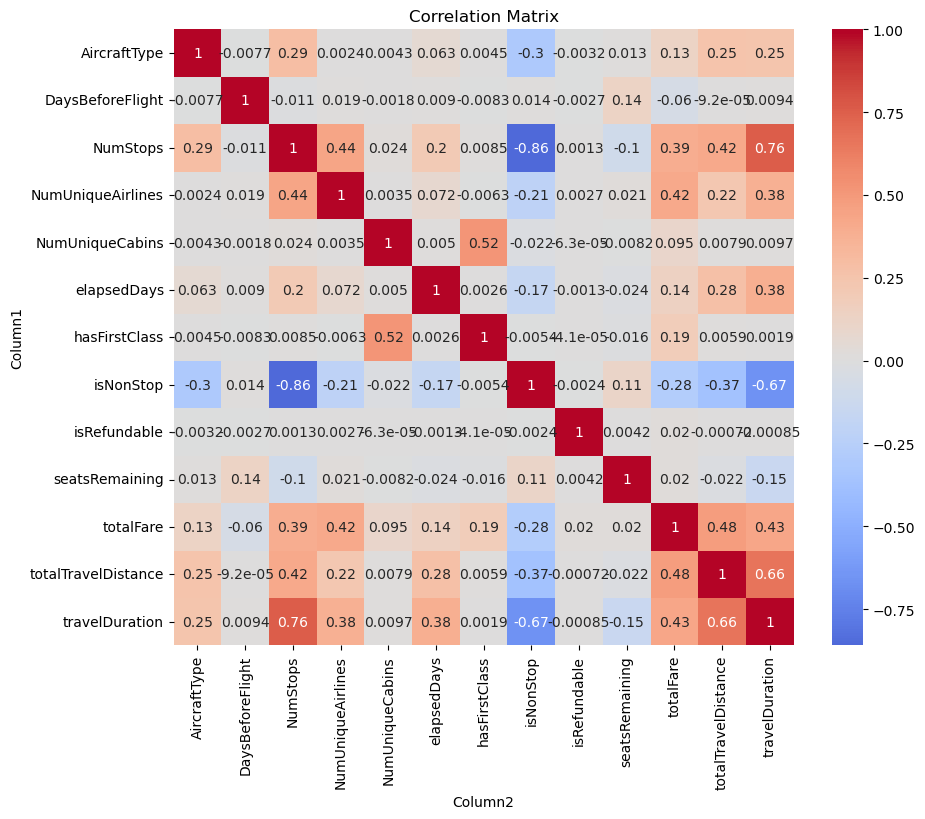

In [ ]:
# Plot heatmap of correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

##### Based on the correlation matrix values, we decided to remove isNonStop as it is highly correlated with NumStops but NumStops captures more information.

In [ ]:
copy_df = copy_df.drop("isNonStop")

## Splitting Data

In [ ]:
# Split data into training, validation, and test sets based on a 75/15/10% split
train_df, val_df, test_df = copy_df.randomSplit([0.75, 0.15, 0.1])

In [ ]:
# Check new data
train_df.show(5)

+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|        AirlineNames|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|
+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|00000115f8d6a1445...|2022-04-21|2022-06-08|            LAX|               ORD|           248|      

In [ ]:
test_df.show(5)

+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+--------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|  AirlineNames|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|
+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+--------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|0000649909dce3a49...|2022-09-23|2022-11-02|            BOS|               ATL|           240|          0|           0

In [ ]:
val_df.show(5)

+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|travelDuration|elapsedDays|isRefundable|totalFare|seatsRemaining|DaysBeforeFlight|Layovers|NumStops|        AirlineNames|NumUniqueAirlines|AircraftType|NumUniqueCabins|hasFirstClass|FlightArrivalDate|totalTravelDistance|
+--------------------+----------+----------+---------------+------------------+--------------+-----------+------------+---------+--------------+----------------+--------+--------+--------------------+-----------------+------------+---------------+-------------+-----------------+-------------------+
|000019591cfd2d4eb...|2022-06-10|2022-08-03|            DEN|               MIA|           621|      

## Data Saving:

#### Storing data as compressed file in gcs bucket

In [ ]:
# Entire dataset for EDA
copy_df.write.format("parquet").save("gs://msca-bdp-student-gcs/Group1/newdata.parquet")

In [ ]:
# Uploading training, testing, and validation dataset for modeling

train_df.write.format("parquet").save("gs://msca-bdp-student-gcs/Group1/traindata.parquet")

test_df.write.format("parquet").save("gs://msca-bdp-student-gcs/Group1/testdata.parquet")

val_df.write.format("parquet").save("gs://msca-bdp-student-gcs/Group1/valdata.parquet")

## Summary of Data Cleaning

#### We repartitioned the data, converted columns to the correct data representations (e.g. columns with data split by "||", one-hot encoding, and converting types), dropped columns that we didn't need for further analysis, imputed new values for missing entries in totalTravelDistance, examined a correlation matrix, split the data into training, validation, and testing sets (75/15/10% split), and uploaded the new dataframes to our gcs bucket using parquet compression.